In [1]:
from common import colors, sbarlw

In [2]:
import os
os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/home/eharkin/projects/5HTGIF-dev


In [3]:
import re
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import pandas as pd
from ezephys import pltools

from grr.Spiketrain import PSTH
from grr.Simulation import GIFnet_Simulation
from grr.Tools import reprint

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'GIF_network')

In [5]:
def infer_gaba_condition(dir_name):
    regex_match = re.search(r'GABA_(.*)', dir_name)
    if regex_match is not None:
        condition = regex_match.groups()[-1]
    elif 'endocannabinoid' == dir_name:
        condition = 'endocannabinoid'
    else:
        raise ValueError('Unrecognized GABA condition {}'.format(dir_name))
    return condition

In [6]:
DATA_PATH = os.path.join('data', 'simulations', 'GIF_network')

sim_dict = {'Circuit': [], 'Mod type': [], 'Condition': [], 'Rep': [], 'Model': [], 'Experiment': []}

experiments = ['wave_input', 'wave_input_baseline_offset']
network_models = [
    'DRN_subsample_base',
    'mPFC_base'
]

for experiment in experiments:
    for network_model in network_models:
        for gaba_condition in os.listdir(os.path.join(DATA_PATH, experiment, network_model)):
            for fname in os.listdir(os.path.join(DATA_PATH, experiment, network_model, gaba_condition)):
                if fname.endswith(('hdf5', 'h5')):

                    sim_dict['Experiment'].append(experiment)
                    sim_dict['Circuit'].append(
                        re.search(r'(DRN|mPFC)_(.*)', network_model).groups()[-2]
                    )
                    sim_dict['Mod type'].append(
                        re.search(r'(DRN|mPFC)_(.*)', network_model).groups()[-1]
                    )
                    sim_dict['Condition'].append(infer_gaba_condition(gaba_condition))
                    sim_dict['Rep'].append(
                        int(re.search(r'rep([0-9]+)', fname).groups()[-1])
                    )
                    sim_dict['Model'].append(
                        GIFnet_Simulation(
                            os.path.join(DATA_PATH, experiment, network_model, gaba_condition, fname), 
                            mode = 'r'
                        )
                    )

sim_df = pd.DataFrame(sim_dict).sort_values(['Mod type', 'Condition', 'Rep'])
sim_df.reset_index(inplace=True, drop=True)
sim_df.head()

,Circuit,Condition,Experiment,Mod type,Model,Rep
0,mPFC,KO,wave_input,base,[ser],0
1,mPFC,KO,wave_input_baseline_offset,base,[ser],0
2,mPFC,KO,wave_input,base,[ser],1
3,mPFC,KO,wave_input_baseline_offset,base,[ser],1
4,mPFC,KO,wave_input,base,[ser],2


In [7]:
sim_df['Principal PSTH'] = None
sim_df['Principal PSTH'] = sim_df['Principal PSTH'].astype(object)
sim_df['GABA PSTH'] = None
sim_df['GABA PSTH'] = sim_df['GABA PSTH'].astype(object)

In [8]:
model_input = {}

with open(os.path.join(DATA_PATH, 'wave_input', 'wave_input.dat'), 'rb') as f:
    model_input['baseline'] = pickle.load(f)
    f.close()
    
with open(os.path.join(DATA_PATH, 'wave_input_baseline_offset', 'wave_input.dat'), 'rb') as f:
    model_input['baseline_offset'] = pickle.load(f)
    f.close()

In [9]:
PSTH_width = 50.

for i in range(sim_df.shape[0]):
    reprint('Computing PSTH {:.1f}%'.format(100. * i / sim_df.shape[0]))
    
    # Get PSTH from 5HT population.
    sim_df.at[i, 'Principal PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
        sim_df.loc[i, 'Principal PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].ser_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_ser_neurons()
        )
    
    # Get PSTHs from GABA population.
    if sim_df.loc[i, 'Condition'] != 'KO':
        sim_df.at[i, 'GABA PSTH'] = np.empty((
            sim_df.loc[i, 'Model'].get_no_sweeps(), 
            sim_df.loc[i, 'Model'].get_no_timesteps()
        ))
        for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
            sim_df.loc[i, 'GABA PSTH'][sweep_no, :] = PSTH(
                sim_df.loc[i, 'Model'].gaba_spktrains[sweep_no, ...].sum(axis = 0),
                PSTH_width,
                sim_df.loc[i, 'Model'].get_no_gaba_neurons()
            )
    else:
        sim_df.loc[i, 'GABA PSTH'] = None
        continue

print('\nDone!')

Computing PSTH 99.2%
Done!


In [10]:
def select_sample_dataset(dframe, circuit, condition, mod_type, rep_num, experiment):
    return dframe.loc[
        (dframe['Circuit'] == circuit)
        & (dframe['Condition'] == condition) 
        & (dframe['Mod type'] == mod_type)
        & (dframe['Rep'] == rep_num)
        & (dframe['Experiment'] == experiment), 
        'Model'
    ].item()

In [11]:
def select_PSTH_dataset(dframe, circuit, condition, mod_type, experiment, psth_type='Principal PSTH'):
    return dframe.loc[
        (dframe['Circuit'] == circuit)
        & (dframe['Condition'] == condition) 
        & (dframe['Mod type'] == mod_type)
        & (dframe['Experiment'] == experiment), 
        psth_type
    ].item()

In [12]:
sim_df.head()

,Circuit,Condition,Experiment,Mod type,Model,Rep,Principal PSTH,GABA PSTH
0,mPFC,KO,wave_input,base,[ser],0,"[[1.1333333333333335, 1.1333333333333335, 1.13...",None
1,mPFC,KO,wave_input_baseline_offset,base,[ser],0,"[[1.8333333333333333, 1.8333333333333333, 1.83...",None
2,mPFC,KO,wave_input,base,[ser],1,"[[0.6666666666666667, 0.6666666666666667, 0.73...",None
3,mPFC,KO,wave_input_baseline_offset,base,[ser],1,"[[1.3333333333333335, 1.3333333333333335, 1.33...",None
4,mPFC,KO,wave_input,base,[ser],2,"[[0.7666666666666667, 0.7666666666666667, 0.76...",None


In [13]:
psth_dict = {'Circuit': [], 'Mod type': [], 'Condition': [], 'Experiment': [], 'Principal PSTH': [], 'GABA PSTH': []}
for experiment in sim_df['Experiment'].unique():
    for circuit in sim_df['Circuit'].unique():
        for modtype in sim_df.loc[sim_df['Circuit'] == circuit, 'Mod type'].unique():
            for cond in sim_df.loc[(sim_df['Circuit'] == circuit) & (sim_df['Mod type'] == modtype), 'Condition'].unique():
                psth_dict['Circuit'].append(circuit)
                psth_dict['Mod type'].append(modtype)
                psth_dict['Condition'].append(cond)
                psth_dict['Experiment'].append(experiment)
                psth_dict['Principal PSTH'].append(np.array(
                    sim_df.loc[
                        (sim_df['Circuit'] == circuit) 
                        & (sim_df['Condition'] == cond) 
                        & (sim_df['Mod type'] == modtype)
                        & (sim_df['Experiment'] == experiment), 
                        'Principal PSTH'
                    ].tolist()
                ))
                psth_dict['GABA PSTH'].append(np.array(
                    sim_df.loc[
                        (sim_df['Circuit'] == circuit) 
                        & (sim_df['Condition'] == cond) 
                        & (sim_df['Mod type'] == modtype)
                        & (sim_df['Experiment'] == experiment), 
                        'GABA PSTH'
                    ].tolist()
                ))
psth_df = pd.DataFrame(psth_dict)
del psth_dict

In [14]:
def get_spike_times(spike_trains, dt):
    spike_trains = np.asarray(spike_trains)
    
    spike_times = []
    for train_ind in range(spike_trains.shape[0]):
        spk_indices = np.where(spike_trains[train_ind, :] > 0.5)[0]
        spike_times.append(spk_indices * dt)
    
    return spike_times

In [15]:
def set_spike_apex(voltage_traces, spike_apex):
    voltage_traces[voltage_traces == 0.] = spike_apex
    return voltage_traces

In [16]:
num_sample_neurons = 20

# PSTH overlay

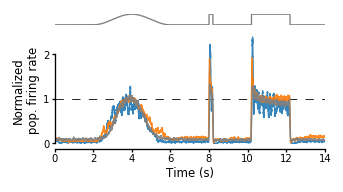

In [18]:
dt=1e-4

psth_by_celltype = {
    'ser': select_PSTH_dataset(psth_df, 'DRN', 'KO', 'subsample_base', 'wave_input', 'Principal PSTH')[0, 0, :],
    'som': select_PSTH_dataset(psth_df, 'DRN', 'base', 'subsample_base', 'wave_input', 'GABA PSTH')[0, 0, :],
    'pyr': select_PSTH_dataset(psth_df, 'mPFC', 'KO', 'base', 'wave_input', 'Principal PSTH')[0, 0, :]
}

t_vec = np.arange(0, (len(psth_by_celltype['ser']) - 0.5) * dt, dt)

spec = gs.GridSpec(2, 1, height_ratios=[0.1, 1], hspace=0.1, left=0.2, right=0.95, bottom=0.2, top=0.95)

plt.figure(figsize=(3, 1.5))

plt.subplot(spec[0, :])
plt.plot(t_vec, model_input['baseline']['ser_input'][0, 0, :], color=colors['input'])
plt.xlim(0, 14)
pltools.hide_border('a')

plt.subplot(spec[1, :])
plt.ylabel('Normalized\npop. firing rate')
plt.xlabel('Time (s)')
plt.axhline(1, color='k', ls='--', lw=0.5, dashes=(10, 10))
for celltype in ['ser', 'som', 'pyr']:
    plt.plot(
        t_vec, 
        psth_by_celltype[celltype] / psth_by_celltype[celltype][39000:40000].mean(), 
        color=colors[celltype],
        alpha=0.9
    )
    
plt.xlim(0, 14)
pltools.hide_border('tr', trim=True)

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'pop_psth_overlay.png'))
    plt.savefig(os.path.join(IMG_PATH, 'pop_psth_overlay.svg'))

# Individual cell types

In [17]:
dt = 1e-4

sample_v_trace = select_sample_dataset(sim_df, 'DRN', 'KO', 'subsample_base', 0, 'wave_input').ser_examples['V'][0, 1, :]
sample_v_trace = set_spike_apex(sample_v_trace, 40.)

t_vec = np.arange(0, (len(sample_v_trace) - 0.5) * dt, dt)

raster_dset = select_sample_dataset(sim_df, 'DRN', 'KO', 'subsample_base', 0, 'wave_input').ser_spktrains[0, :num_sample_neurons, :]
spk_times = get_spike_times(raster_dset, dt)

psth_dset = select_PSTH_dataset(psth_df, 'DRN', 'KO', 'subsample_base', 'wave_input', 'Principal PSTH')[0, 0, :]

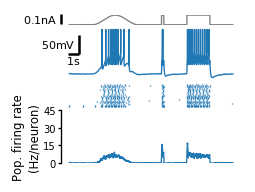

In [18]:
spec = gs.GridSpec(4, 1, height_ratios=[0.2, 1, 0.5, 1], hspace=0.05, top=0.95, right=0.95, left=0.2)

plt.figure(figsize=(2, 1.5))

plt.subplot(spec[0, :])
plt.plot(t_vec, model_input['baseline']['ser_input'][0, 0, :], color=colors['input'])
pltools.add_scalebar(y_units='nA', y_size=0.1, anchor=(0, 0.1), round=False, omit_x=True, linewidth=sbarlw)

V_ax = plt.subplot(spec[1, :])
plt.plot(t_vec, sample_v_trace, color=colors['ser'])
pltools.add_scalebar('s', 'mV', x_size=1, anchor=(0.1, 0.5), bar_space=0, linewidth=sbarlw)

plt.subplot(spec[2, :])
plt.eventplot(spk_times, color=colors['ser'])
plt.xlim(V_ax.get_xlim())
pltools.hide_border('a')
pltools.hide_ticks()

plt.subplot(spec[3, :])
plt.plot(t_vec, psth_dset, color=colors['ser'])
plt.yticks([0, 15, 30, 45])
plt.ylim(0, 45)
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.xlim(V_ax.get_xlim())
pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'ser_population_sample.png'))
    plt.savefig(os.path.join(IMG_PATH, 'ser_population_sample.svg'))

In [19]:
dt = 1e-4

sample_v_trace = select_sample_dataset(sim_df, 'DRN', 'KO', 'subsample_base', 0, 'wave_input_baseline_offset').ser_examples['V'][0, 1, :]
sample_v_trace = set_spike_apex(sample_v_trace, 40.)

t_vec = np.arange(0, (len(sample_v_trace) - 0.5) * dt, dt)

raster_dset = select_sample_dataset(sim_df, 'DRN', 'KO', 'subsample_base', 0, 'wave_input_baseline_offset').ser_spktrains[0, :num_sample_neurons, :]
spk_times = get_spike_times(raster_dset, dt)

psth_dset = select_PSTH_dataset(psth_df, 'DRN', 'KO', 'subsample_base', 'wave_input_baseline_offset', 'Principal PSTH')[0, 0, :]

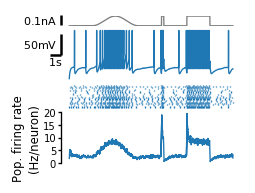

In [20]:
spec = gs.GridSpec(4, 1, height_ratios=[0.2, 1, 0.5, 1], hspace=0.05, top=0.95, right=0.95, left=0.2)

plt.figure(figsize=(2, 1.5))

plt.subplot(spec[0, :])
plt.plot(t_vec, model_input['baseline_offset']['ser_input'][0, 0, :], color=colors['input'])
pltools.add_scalebar(y_units='nA', y_size=0.1, anchor=(0, 0.1), round=False, omit_x=True, linewidth=sbarlw)

V_ax = plt.subplot(spec[1, :])
plt.plot(t_vec, sample_v_trace, color=colors['ser'])
pltools.add_scalebar('s', 'mV', x_size=1, anchor=(0., 0.5), bar_space=0, linewidth=sbarlw)

plt.subplot(spec[2, :])
plt.eventplot(spk_times, color=colors['ser'])
plt.xlim(V_ax.get_xlim())
pltools.hide_border('a')
pltools.hide_ticks()

plt.subplot(spec[3, :])
plt.plot(t_vec, psth_dset, color=colors['ser'])
plt.yticks([0, 5, 10, 15, 20])
#plt.ylim(0, 45)
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.xlim(V_ax.get_xlim())
pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'ser_population_baseline_offset_sample.png'))
    plt.savefig(os.path.join(IMG_PATH, 'ser_population_baseline_offset_sample.svg'))

# SOM

In [21]:
num_sample_neurons = 20

In [22]:
dt = 1e-4

sample_v_trace = select_sample_dataset(sim_df, 'DRN', 'base', 'subsample_base', 0, 'wave_input').gaba_examples['V'][0, 5, :]
sample_v_trace = set_spike_apex(sample_v_trace, 40.)

t_vec = np.arange(0, (len(sample_v_trace) - 0.5) * dt, dt)

raster_dset = select_sample_dataset(sim_df, 'DRN', 'base', 'subsample_base', 0, 'wave_input').gaba_spktrains[0, :num_sample_neurons, :]
spk_times = get_spike_times(raster_dset, dt)

psth_dset = select_PSTH_dataset(psth_df, 'DRN', 'base', 'subsample_base', 'wave_input', 'GABA PSTH')[0, 0, :]

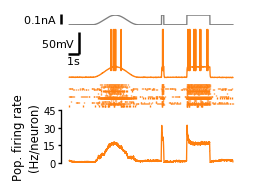

In [23]:
spec = gs.GridSpec(4, 1, height_ratios=[0.2, 1, 0.5, 1], hspace=0.05, top=0.95, right=0.95, left=0.2)

plt.figure(figsize=(2, 1.5))

plt.subplot(spec[0, :])
plt.plot(t_vec, model_input['baseline']['gaba_input'][0, 0, :], color=colors['input'])
pltools.add_scalebar(y_units='nA', y_size=0.1, anchor=(0, 0.1), round=False, omit_x=True, linewidth=sbarlw)

V_ax = plt.subplot(spec[1, :])
plt.plot(t_vec, sample_v_trace, color=colors['som'])
pltools.add_scalebar('s', 'mV', x_size=1, anchor=(0.1, 0.5), bar_space=0, linewidth=sbarlw)

plt.subplot(spec[2, :])
plt.eventplot(spk_times, color=colors['som'])
plt.xlim(V_ax.get_xlim())
pltools.hide_border('a')
pltools.hide_ticks()

plt.subplot(spec[3, :])
plt.plot(t_vec, psth_dset, color=colors['som'])
plt.yticks([0, 15, 30, 45])
plt.ylim(0, 45)
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.xlim(V_ax.get_xlim())
pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_population_sample.png'))
    plt.savefig(os.path.join(IMG_PATH, 'som_population_sample.svg'))

In [24]:
dt = 1e-4

sample_v_trace = select_sample_dataset(sim_df, 'DRN', 'base', 'subsample_base', 0, 'wave_input_baseline_offset').gaba_examples['V'][0, 5, :]
sample_v_trace = set_spike_apex(sample_v_trace, 40.)

t_vec = np.arange(0, (len(sample_v_trace) - 0.5) * dt, dt)

raster_dset = select_sample_dataset(sim_df, 'DRN', 'base', 'subsample_base', 0, 'wave_input_baseline_offset').gaba_spktrains[0, :num_sample_neurons, :]
spk_times = get_spike_times(raster_dset, dt)

psth_dset = select_PSTH_dataset(psth_df, 'DRN', 'base', 'subsample_base', 'wave_input_baseline_offset', 'GABA PSTH')[0, 0, :]

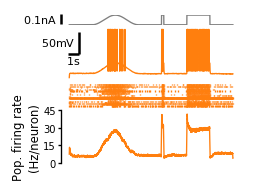

In [25]:
spec = gs.GridSpec(4, 1, height_ratios=[0.2, 1, 0.5, 1], hspace=0.05, top=0.95, right=0.95, left=0.2)

plt.figure(figsize=(2, 1.5))

plt.subplot(spec[0, :])
plt.plot(t_vec, model_input['baseline']['gaba_input'][0, 0, :], color=colors['input'])
pltools.add_scalebar(y_units='nA', y_size=0.1, anchor=(0, 0.1), round=False, omit_x=True, linewidth=sbarlw)

V_ax = plt.subplot(spec[1, :])
plt.plot(t_vec, sample_v_trace, color=colors['som'])
pltools.add_scalebar('s', 'mV', x_size=1, anchor=(0.1, 0.5), bar_space=0, linewidth=sbarlw)

plt.subplot(spec[2, :])
plt.eventplot(spk_times, color=colors['som'])
plt.xlim(V_ax.get_xlim())
pltools.hide_border('a')
pltools.hide_ticks()

plt.subplot(spec[3, :])
plt.plot(t_vec, psth_dset, color=colors['som'])
plt.yticks([0, 15, 30, 45])
plt.ylim(0, plt.ylim()[1])
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.xlim(V_ax.get_xlim())
pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_population_baseline_offset_sample.png'))
    plt.savefig(os.path.join(IMG_PATH, 'som_population_baseline_offset_sample.svg'))

# mPFC

In [26]:
num_sample_neurons = 20

In [27]:
dt = 1e-4

sample_v_trace = select_sample_dataset(sim_df, 'mPFC', 'KO', 'base', 0, 'wave_input').ser_examples['V'][0, 1, :]
sample_v_trace = set_spike_apex(sample_v_trace, 40.)

t_vec = np.arange(0, (len(sample_v_trace) - 0.5) * dt, dt)

raster_dset = select_sample_dataset(sim_df, 'mPFC', 'KO', 'base', 0, 'wave_input').ser_spktrains[0, :num_sample_neurons, :]
spk_times = get_spike_times(raster_dset, dt)

psth_dset = select_PSTH_dataset(psth_df, 'mPFC', 'KO', 'base', 'wave_input', 'Principal PSTH')[0, 0, :]

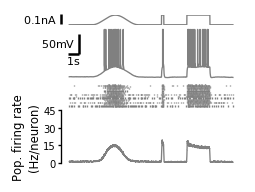

In [28]:
spec = gs.GridSpec(4, 1, height_ratios=[0.2, 1, 0.5, 1], hspace=0.05, top=0.95, right=0.95, left=0.2)

plt.figure(figsize=(2, 1.5))

plt.subplot(spec[0, :])
plt.plot(t_vec, model_input['baseline']['ser_input'][0, 0, :], color=colors['input'])
pltools.add_scalebar(y_units='nA', y_size=0.1, anchor=(0, 0.1), round=False, omit_x=True, linewidth=sbarlw)

V_ax = plt.subplot(spec[1, :])
plt.plot(t_vec, sample_v_trace, color=colors['pyr'])
pltools.add_scalebar('s', 'mV', x_size=1, anchor=(0.1, 0.5), bar_space=0, linewidth=sbarlw)

plt.subplot(spec[2, :])
plt.eventplot(spk_times, color=colors['pyr'])
plt.xlim(V_ax.get_xlim())
pltools.hide_border('a')
pltools.hide_ticks()

plt.subplot(spec[3, :])
plt.plot(t_vec, psth_dset, color=colors['pyr'])
plt.yticks([0, 15, 30, 45])
plt.ylim(0, 45)
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.xlim(V_ax.get_xlim())
pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'mPFC_population_sample.png'))
    plt.savefig(os.path.join(IMG_PATH, 'mPFC_population_sample.svg'))

In [29]:
dt = 1e-4

sample_v_trace = select_sample_dataset(sim_df, 'mPFC', 'KO', 'base', 0, 'wave_input_baseline_offset').ser_examples['V'][0, 1, :]
sample_v_trace = set_spike_apex(sample_v_trace, 40.)

t_vec = np.arange(0, (len(sample_v_trace) - 0.5) * dt, dt)

raster_dset = select_sample_dataset(sim_df, 'mPFC', 'KO', 'base', 0, 'wave_input_baseline_offset').ser_spktrains[0, :num_sample_neurons, :]
spk_times = get_spike_times(raster_dset, dt)

psth_dset = select_PSTH_dataset(psth_df, 'mPFC', 'KO', 'base', 'wave_input_baseline_offset', 'Principal PSTH')[0, 0, :]

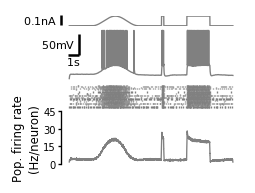

In [30]:
spec = gs.GridSpec(4, 1, height_ratios=[0.2, 1, 0.5, 1], hspace=0.05, top=0.95, right=0.95, left=0.2)

plt.figure(figsize=(2, 1.5))

plt.subplot(spec[0, :])
plt.plot(t_vec, model_input['baseline_offset']['ser_input'][0, 0, :], color=colors['input'])
pltools.add_scalebar(y_units='nA', y_size=0.1, anchor=(0, 0.1), round=False, omit_x=True, linewidth=sbarlw)

V_ax = plt.subplot(spec[1, :])
plt.plot(t_vec, sample_v_trace, color=colors['pyr'])
pltools.add_scalebar('s', 'mV', x_size=1, anchor=(0.1, 0.5), bar_space=0, linewidth=sbarlw)

plt.subplot(spec[2, :])
plt.eventplot(spk_times, color=colors['pyr'])
plt.xlim(V_ax.get_xlim())
pltools.hide_border('a')
pltools.hide_ticks()

plt.subplot(spec[3, :])
plt.plot(t_vec, psth_dset, color=colors['pyr'])
plt.yticks([0, 15, 30, 45])
plt.ylim(0, 45)
plt.ylabel('Pop. firing rate\n(Hz/neuron)')
plt.xlim(V_ax.get_xlim())
pltools.hide_border('trb', trim=True)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'mPFC_population_baseline_offset_sample.png'))
    plt.savefig(os.path.join(IMG_PATH, 'mPFC_population_baseline_offset_sample.svg'))